In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=b9553a3ee1b24e45efec88ffb0951506fee50326d8b8e56c55d1d1b14a655eaf
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, Dense, Attention, AdditiveAttention, Concatenate
from sklearn.model_selection import train_test_split
import time
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer



<ipython-input-4-c0ade455e8af>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
<ipython-input-4-c0ade455e8af>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text_len'] = data['text'].apply(lambda x: len(x.split()))
<ipython-input-4-c0ade455e8af>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

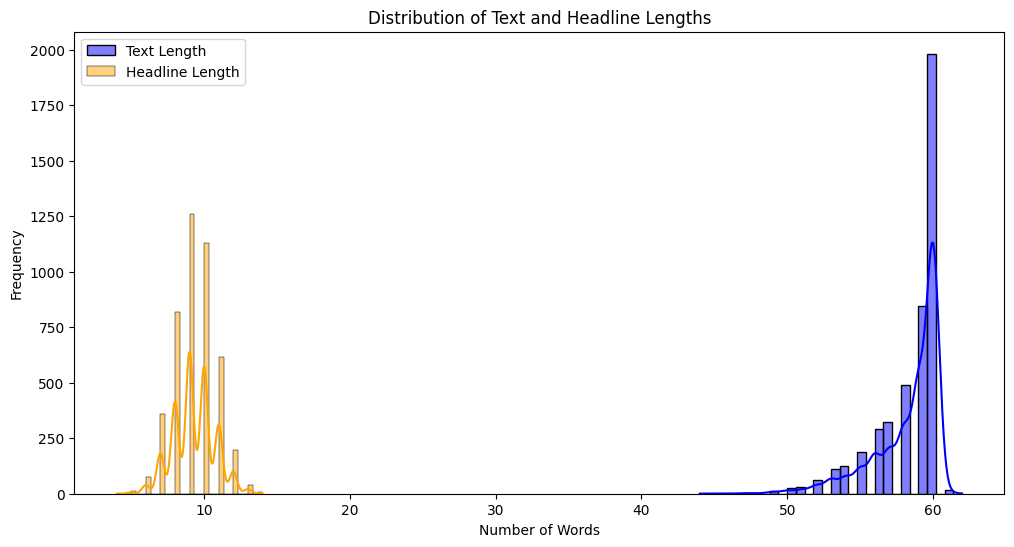

In [ ]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer  # Keras tokenizer for text preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences  # For padding sequences to fixed length
from sklearn.model_selection import train_test_split  # To split dataset into training and testing sets

# Load the dataset with specified encoding
data = pd.read_csv('/content/news_summary.csv', encoding='ISO-8859-1')

# Keep only the relevant columns: 'text' for input and 'headlines' for target
data = data[['text', 'headlines']]

# Remove rows with missing values
data.dropna(inplace=True)

# Calculate the number of words in each text and headline
data['text_len'] = data['text'].apply(lambda x: len(x.split()))
data['headline_len'] = data['headlines'].apply(lambda x: len(x.split()))

# Plot histogram showing distribution of word lengths in text and headline
plt.figure(figsize=(12, 6))
sns.histplot(data['text_len'], bins=30, kde=True, color='blue', label='Text Length')      # Distribution for 'text'
sns.histplot(data['headline_len'], bins=30, kde=True, color='orange', label='Headline Length')  # Distribution for 'headlines'
plt.title('Distribution of Text and Headline Lengths')  # Title of the plot
plt.xlabel('Number of Words')  # X-axis label
plt.ylabel('Frequency')        # Y-axis label
plt.legend()                   # Display legend
plt.show()                     # Show the plot


In [ ]:
# Tokenize the input texts
text_tokenizer = Tokenizer()  # Initialize tokenizer for text data
text_tokenizer.fit_on_texts(data['text'])  # Learn the vocabulary from the text column
text_seq = text_tokenizer.texts_to_sequences(data['text'])  # Convert text to sequence of integers (word indices)

# Tokenize the target headlines
headline_tokenizer = Tokenizer()  # Initialize tokenizer for headline data
headline_tokenizer.fit_on_texts(data['headlines'])  # Learn the vocabulary from the headline column
headline_seq = headline_tokenizer.texts_to_sequences(data['headlines'])  # Convert headlines to sequences

# Define maximum sequence lengths
max_text_len = 30        # Limit the input text to 30 tokens
max_headline_len = 10    # Limit the headline (summary) to 10 tokens

# Pad the input text sequences to ensure uniform length
text_seq = pad_sequences(text_seq, maxlen=max_text_len, padding='post')
# Padding is added after the actual sequence ('post') so all sequences are of length 30

# Pad the headline sequences similarly
headline_seq = pad_sequences(headline_seq, maxlen=max_headline_len, padding='post')
# Ensures all headline sequences are of length 10 for model input


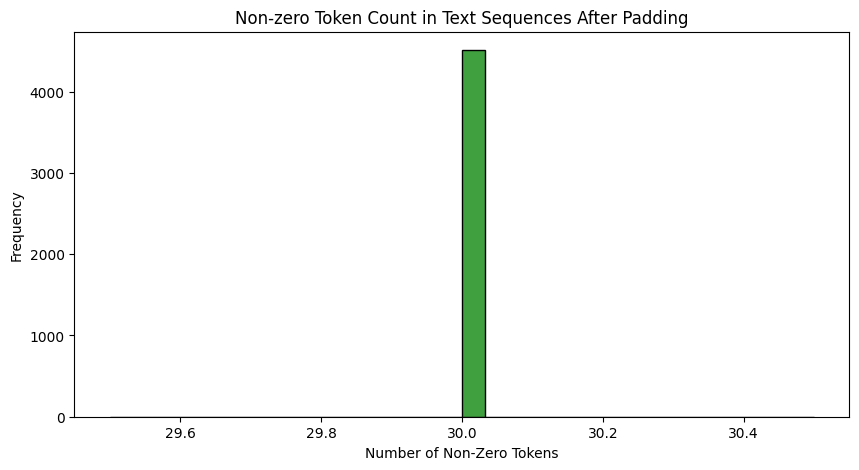

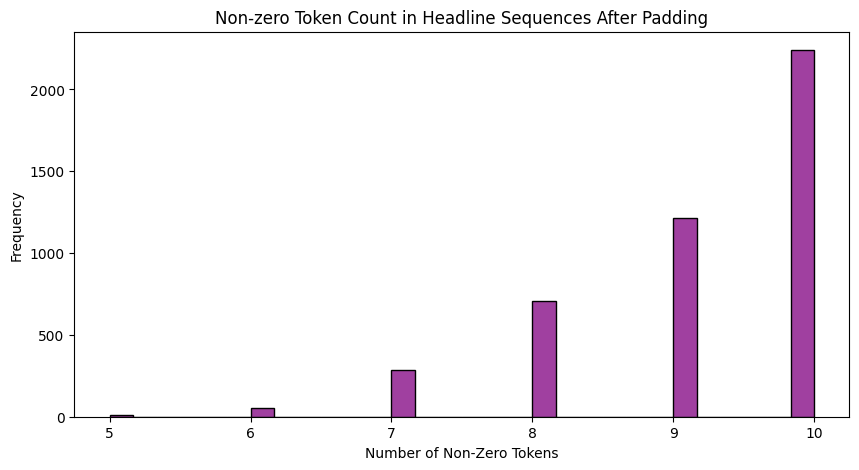

In [ ]:
# Visualize the distribution of non-zero tokens in the text sequences after padding
plt.figure(figsize=(10, 5))  # Set figure size for the plot
# Plot histogram showing the number of non-zero tokens in each padded text sequence
# [len(seq[seq > 0]) for seq in text_seq] counts the number of non-zero tokens (i.e., actual words) in each sequence
sns.histplot([len(seq[seq > 0]) for seq in text_seq], bins=30, color='green')
plt.title('Non-zero Token Count in Text Sequences After Padding')  # Title of the plot
plt.xlabel('Number of Non-Zero Tokens')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.show()  # Display the plot

# Visualize the distribution of non-zero tokens in the headline sequences after padding
plt.figure(figsize=(10, 5))  # Set figure size for the plot
# Plot histogram showing the number of non-zero tokens in each padded headline sequence
sns.histplot([len(seq[seq > 0]) for seq in headline_seq], bins=30, color='purple')
plt.title('Non-zero Token Count in Headline Sequences After Padding')  # Title of the plot
plt.xlabel('Number of Non-Zero Tokens')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.show()  # Display the plot


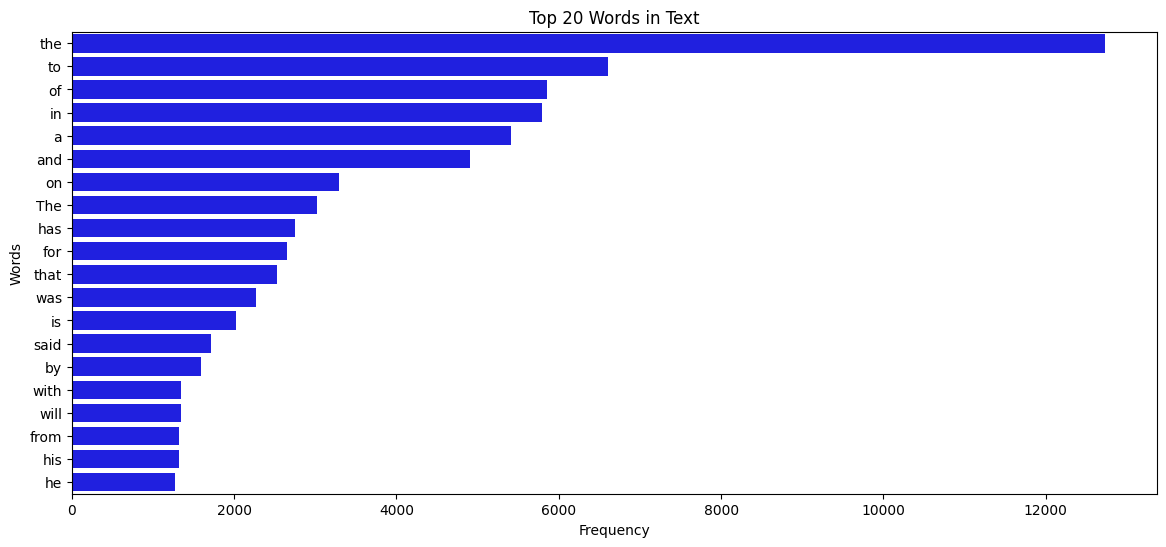

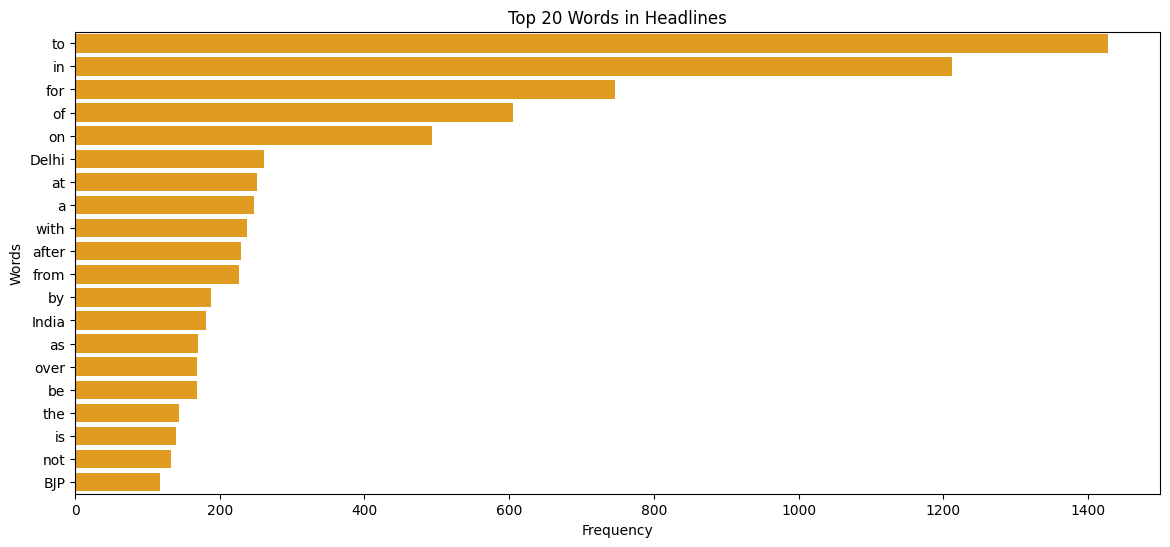

In [ ]:
# Import necessary libraries for word frequency calculation
from collections import Counter  # To count word frequencies
import itertools  # To flatten list of words from text and headlines

# Flatten the 'text' and 'headlines' columns into single lists of words
text_words = list(itertools.chain.from_iterable([text.split() for text in data['text']]))  # Flatten the text words
headline_words = list(itertools.chain.from_iterable([headline.split() for headline in data['headlines']]))  # Flatten the headline words

# Calculate the top 20 most frequent words in the text and headlines using Counter
top_text_words = dict(Counter(text_words).most_common(20))  # Top 20 words in text
top_headline_words = dict(Counter(headline_words).most_common(20))  # Top 20 words in headlines

# Visualize the top 20 most frequent words in the text
plt.figure(figsize=(14, 6))  # Set figure size for better visibility
sns.barplot(x=list(top_text_words.values()), y=list(top_text_words.keys()), color='blue')  # Bar plot of top 20 text words
plt.title('Top 20 Words in Text')  # Title of the plot
plt.xlabel('Frequency')  # X-axis label showing word frequency
plt.ylabel('Words')  # Y-axis label showing the words
plt.show()  # Display the plot

# Visualize the top 20 most frequent words in the headlines
plt.figure(figsize=(14, 6))  # Set figure size for better visibility
sns.barplot(x=list(top_headline_words.values()), y=list(top_headline_words.keys()), color='orange')  # Bar plot of top 20 headline words
plt.title('Top 20 Words in Headlines')  # Title of the plot
plt.xlabel('Frequency')  # X-axis label showing word frequency
plt.ylabel('Words')  # Y-axis label showing the words
plt.show()  # Display the plot


In [ ]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(text_seq, headline_seq, test_size=0.1)


In [ ]:
# =======================
# 1. Set Embedding Dimension and Calculate Vocabulary Sizes
# =======================
embedding_dim = 100  # Define the dimension of the word embeddings
vocab_text = len(text_tokenizer.word_index) + 1  # Vocabulary size for the input text (+1 to account for padding)
vocab_headline = len(headline_tokenizer.word_index) + 1  # Vocabulary size for the headlines (+1 to account for padding)

# =======================
# 2. Encoder (No Attention)
# =======================
enc_input = Input(shape=(max_text_len,))  # Input layer for the encoder, with sequence length equal to max_text_len
enc_emb = Embedding(vocab_text, embedding_dim)(enc_input)  # Embed the input text using an embedding layer
# GRU layer for the encoder with 256 units, returns the last state (state_h) used as the initial state for the decoder
enc_output, state_h = GRU(256, return_state=True, return_sequences=True)(enc_emb)  # FIXED
# =======================
# 3. Decoder (No Attention)
# =======================
dec_input = Input(shape=(max_headline_len - 1,))  # Input layer for the decoder (headline input, reduced by 1 for teacher forcing)
dec_emb = Embedding(vocab_headline, embedding_dim)(dec_input)  # Embed the headline input using an embedding layer
# GRU layer for the decoder, with the initial state set to the encoder's final hidden state (state_h)

dec_gru = GRU(256, return_sequences=True)(dec_emb, initial_state=state_h)
# Output layer for the decoder, using a softmax activation to output the probability distribution for each word
dec_output = Dense(vocab_headline, activation='softmax')(dec_gru)

# =======================
# 4. Model Definition and Compilation
# =======================
# Define the model with the encoder input, decoder input, and decoder output
model = Model([enc_input, dec_input], dec_output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# =======================
# 5. Model Training
# =======================
start = time.time()  # Start time for training
history = model.fit(
    [x_train, y_train[:, :-1]],  # Training input (text) and target (headline) sequences, shifted by 1 for teacher forcing
    y_train[:, 1:].reshape(y_train.shape[0], y_train.shape[1] - 1, 1),  # Adjust target to align with decoder output
    epochs=10,  # Number of epochs for training
    validation_split=0.1  # Use 10% of data for validation
)
end = time.time()  # End time for training
lstm_time = end - start  # Calculate the time taken for training


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 88s 721ms/step - accuracy: 0.0924 - loss: 8.3420 - val_accuracy: 0.1215 - val_loss: 7.4279
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 139s 698ms/step - accuracy: 0.1214 - loss: 6.9999 - val_accuracy: 0.1242 - val_loss: 7.4299
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 81s 691ms/step - accuracy: 0.1305 - loss: 6.6870 - val_accuracy: 0.1310 - val_loss: 7.4488
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 83s 700ms/step - accuracy: 0.1321 - loss: 6.4331 - val_accuracy: 0.1299 - val_loss: 7.5197
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 81s 696ms/step - accuracy: 0.1360 - loss: 6.1971 - val_accuracy: 0.1245 - val_loss: 7.6379
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 81s 706ms/step - accuracy: 0.1415 - loss: 5.9091 - val_accuracy: 0.1215 - val_loss: 7.7442
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 83s 712ms/step - accuracy: 0.1516 - loss: 5.5570 - val_accuracy: 0.1229 - val_loss: 7.8774
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 142s 715ms/step - accuracy: 0.1601 - loss:

In [ ]:
# =======================
# 6. Loss and Accuracy Curves
# =======================
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# =======================
# 1. Encoder Definition
# =======================
# Input layer for the encoder: the sequence length of the text is defined by max_text_len
enc_input = Input(shape=(max_text_len,))

# Embedding layer: Transform words into dense vectors (embedding_dim defines the dimension of the embedding space)
enc_emb = Embedding(vocab_text, embedding_dim)(enc_input)

# GRU layer for the encoder: This layer processes the input text, and we capture the final state (enc_state) for initializing the decoder
enc_output, enc_state = GRU(256, return_sequences=True, return_state=True)(enc_emb)  # return_state=True for passing the final state to the decoder

# =======================
# 2. Decoder Definition
# =======================
# Input layer for the decoder: Sequence length is reduced by 1 due to teacher forcing
dec_input = Input(shape=(max_headline_len - 1,))

# Embedding layer for decoder input: Words are transformed into dense vectors
dec_emb = Embedding(vocab_headline, embedding_dim)(dec_input)

# GRU layer for the decoder: The initial state of the decoder is set to the final hidden state of the encoder (enc_state)
dec_output, _ = GRU(256, return_sequences=True, return_state=True)(dec_emb, initial_state=enc_state)

# =======================
# 3. Attention Layer
# =======================
# AdditiveAttention layer computes the attention weights (context_vector) based on decoder outputs and encoder outputs
attention = AdditiveAttention()

# The context vector captures the weighted sum of encoder outputs based on attention scores for each time step of the decoder output
context_vector = attention([dec_output, enc_output])

# =======================
# 4. Concatenation of Context and Decoder Output
# =======================
# The context vector and decoder output are concatenated to provide a richer representation for prediction
concat = Concatenate(axis=-1)([context_vector, dec_output])

# =======================
# 5. Final Output Layer
# =======================
# Output layer using softmax to predict the next word in the headline sequence, given the context and decoder output
final_output = Dense(vocab_headline, activation='softmax')(concat)

# =======================
# 6. Model Definition and Compilation
# =======================
# Define the model by specifying inputs (encoder input, decoder input) and output (final output)
attention_model = Model([enc_input, dec_input], final_output)

# Compile the model with the Adam optimizer and sparse categorical crossentropy loss (since we are predicting class probabilities for each word in the sequence)
attention_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# =======================
# 7. Model Training
# =======================
# Start time for training
start = time.time()

# Train the model: Use shifted sequences for the decoder (y_train[:, :-1]) as input and align the target sequences for output (y_train[:, 1:])
attn_history = attention_model.fit(
    [x_train, y_train[:, :-1]],  # Decoder input (the input sequence with shifted target words)
    y_train[:, 1:].reshape(y_train.shape[0], y_train.shape[1] - 1, 1),  # Decoder output (aligned target sequences for the model to predict)
    epochs=10,  # Training for 10 epochs
    validation_split=0.1  # Use 10% of data for validation during training
)

# End time for training
end = time.time()

# Calculate the total training time
attention_time = end - start


Epoch 1/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.1020 - loss: 8.1799 - val_accuracy: 0.1269 - val_loss: 7.3582
Epoch 2/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.1229 - loss: 6.9320 - val_accuracy: 0.1324 - val_loss: 7.3246
Epoch 3/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.1306 - loss: 6.5975 - val_accuracy: 0.1324 - val_loss: 7.4318
Epoch 4/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.1354 - loss: 6.3295 - val_accuracy: 0.1305 - val_loss: 7.5460
Epoch 5/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.1422 - loss: 6.0628 - val_accuracy: 0.1299 - val_loss: 7.7134
Epoch 6/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.1506 - loss: 5.7304 - val_accuracy: 0.1267 - val_loss: 7.8818
Epoch 7/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.1575 - loss: 5.3931 - val_accuracy: 0.1269 - val_loss: 8.0585
Epoch 8/10
115/115 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.1703 - loss: 5.0189 - val_accu

In [ ]:
import matplotlib.pyplot as plt

# =======================
# 8. Visualization of Training and Validation Loss
# =======================
plt.figure(figsize=(12, 6))
plt.plot(attn_history.history['loss'], label='Training Loss', color='blue')
plt.plot(attn_history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# =======================
# 9. Visualization of Training and Validation Accuracy
# =======================
plt.figure(figsize=(12, 6))
plt.plot(attn_history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(attn_history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd

# Load your dataset, specifying the correct encoding
data = pd.read_csv('/content/news_summary.csv', encoding='ISO-8859-1')  # or encoding='latin1'

# Check if the required columns are present
print(data.columns)

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')


In [ ]:
from transformers import T5Tokenizer, TFT5ForConditionalGeneration
import tensorflow as tf
import time  # ✅ Needed for timing

# =======================
# 1. Load the T5 Model and Tokenizer
# =======================
# Initialize the T5 tokenizer and model (using the small version of T5 for conditional generation tasks)
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model_t5 = TFT5ForConditionalGeneration.from_pretrained('t5-small')

# =======================
# 2. Prepare the Data
# =======================
# Assuming 'text' contains the news articles and 'headlines' contains the corresponding headlines
texts = data['text'][:1000].tolist()  # Extract first 1000 news articles
headlines = data['headlines'][:1000].tolist()  # Extract corresponding headlines

# Convert any non-string elements in 'texts' to strings (in case there are unexpected types)
texts = [str(t) for t in texts]

# =======================
# 3. Batch Processing
# =======================
batch_size = 100  # Number of examples to process at once. Can reduce if memory issues occur.

start = time.time()  # Start the timer to track processing time
losses = []  # List to store loss values for each batch

# =======================
# 4. Process the Data in Batches
# =======================
for i in range(0, len(texts), batch_size):
    # Prepare the input data by prefixing 'summarize: ' to each article for the T5 model
    batch_texts = ['summarize: ' + t for t in texts[i:i+batch_size]]
    batch_heads = headlines[i:i+batch_size]  # Corresponding headlines (target sequences)

    # Tokenize the inputs and targets
    inputs = tokenizer(batch_texts, return_tensors='tf', padding=True, truncation=True)
    targets = tokenizer(batch_heads, return_tensors='tf', padding=True, truncation=True)

    # Run the T5 model to get the outputs (calculate loss based on model predictions and actual targets)
    outputs = model_t5(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, labels=targets.input_ids)

    # Append the loss value for this batch to the losses list
    losses.append(outputs.loss.numpy())

# =======================
# 5. Calculate Total Time and Average Loss
# =======================
end = time.time()  # End the timer
transformer_time = end - start  # Calculate the total time taken for processing

# Print the average loss over all batches and the total time taken
print(f"Average loss: {sum(losses)/len(losses)}")
print(f"Time taken: {transformer_time:.2f} seconds")


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Average loss: [9.679522]
Time taken: 201.32 seconds


In [ ]:
import matplotlib.pyplot as plt
# =======================
# 6. Plotting the Loss Graph
# =======================
# Plot the loss for each batch
plt.plot(losses)
plt.title('Training Loss over Batches')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

NameError: name 'losses' is not defined

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np

def evaluate_metrics(y_true, y_pred):
    """
    Evaluates BLEU and ROUGE scores for a given set of true and predicted sentences.

    Parameters:
    y_true (list): List of reference sentences (actual headlines).
    y_pred (list): List of predicted sentences (generated headlines).

    Returns:
    tuple: BLEU score (float), Average ROUGE scores (dict with rouge1, rouge2, rougeL)
    """

    # Initialize ROUGE scorer for 'rouge1', 'rouge2', and 'rougeL' using stemming
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Use SmoothingFunction to handle BLEU score issues with short or repetitive sequences
    smooth_fn = SmoothingFunction().method1  # This helps avoid BLEU score of 0 for short sentences

    # ==========================
    # Compute BLEU scores
    # ==========================
    # BLEU score measures the precision of n-grams between the predicted and reference sentences
    bleu_scores = [sentence_bleu([ref.split()], pred.split(), smoothing_function=smooth_fn)
                   for ref, pred in zip(y_true, y_pred)]  # Splitting sentences into words before comparison
    bleu = np.mean(bleu_scores)  # Calculate the average BLEU score across all sentences

    # ==========================
    # Compute ROUGE scores
    # ==========================
    # ROUGE evaluates the recall of n-grams (or sequences) in the predicted sentence
    rouge_results = [scorer.score(ref, pred) for ref, pred in zip(y_true, y_pred)]

    # Averaging ROUGE scores across all sentences
    avg_rouge = {
        'rouge1': np.mean([score['rouge1'].fmeasure for score in rouge_results]),  # ROUGE-1 (unigrams)
        'rouge2': np.mean([score['rouge2'].fmeasure for score in rouge_results]),  # ROUGE-2 (bigrams)
        'rougeL': np.mean([score['rougeL'].fmeasure for score in rouge_results]),  # ROUGE-L (longest common subsequence)
    }

    return bleu, avg_rouge  # Return both BLEU score and the average ROUGE scores

# Example test inputs
predicted = ["the headline is generated"]  # Replace with your model's output
references = ["this is the reference headline"]  # Replace with actual reference headlines

# ==========================
# Evaluate the model's predictions
# ==========================
bleu, rouge_scores = evaluate_metrics(references, predicted)  # Calculate BLEU and ROUGE scores
print(f"BLEU: {bleu:.4f}\nROUGE: {rouge_scores}")  # Print the evaluation results


BLEU: 0.0823
ROUGE: {'rouge1': np.float64(0.6666666666666665), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.4444444444444445)}


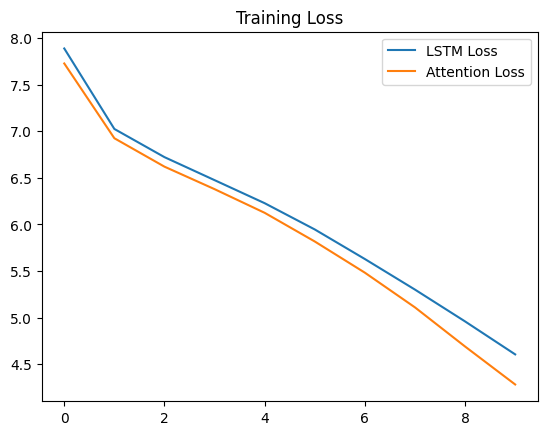

In [ ]:
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib

plt.plot(history.history['loss'], label='LSTM Loss')
plt.plot(attn_history.history['loss'], label='Attention Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

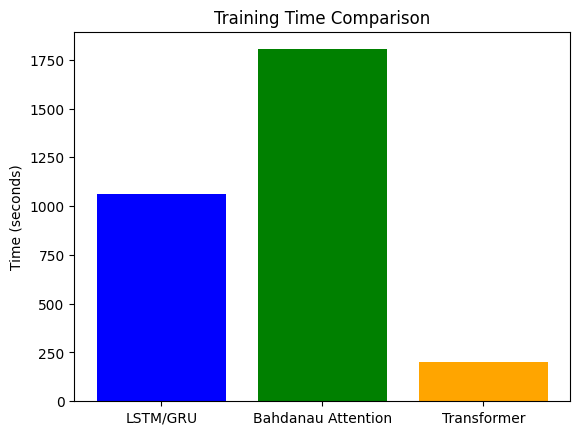

In [ ]:
# Bar Chart of Training Times
models = ['LSTM/GRU', 'Bahdanau Attention', 'Transformer']
times = [lstm_time, attention_time, transformer_time]
plt.bar(models, times, color=['blue', 'green', 'orange'])
plt.title('Training Time Comparison')
plt.ylabel('Time (seconds)')
plt.show()
